# `pyroomacoustics` demo

In this IPython notebook, we demonstrate a few features of `pyroomacoustics`:

1. Its _pythonic_ and convenient object-oriented interface.
2. The Room Impulse Response (RIR) generator.
3. Provided reference algorithms. 

Below is a list of the examples (run all cells as some may depend on previous imports and results). 

1. [Creating a 2D/3D room](#room)
2. [Adding sources and microphones](#source_mic)
3. [Room Impulse Response generation and propagation simulation](#rir)
4. [Beamforming](#bf)
5. [Direction-of-arrival](#doa)
6. [Adaptive filtering](#af)
7. [STFT processing](#stft)
8. [Source Separation](#bss)

More information on the package can be found on the [Github repo](https://github.com/LCAV/pyroomacoustics) and from the [paper](https://arxiv.org/pdf/1710.04196.pdf), which can be cited as:

_R. Scheibler, E. Bezzam, I. Dokmanić, Pyroomacoustics: A Python package for audio room simulations and array processing algorithms, Proc. IEEE ICASSP, Calgary, CA, 2018._

Let's begin by importing the necessary libraries all of which can be installed with `pip`, even `pyroomacoustics`!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import scipy.signal as sg
import IPython
import pyroomacoustics as pra

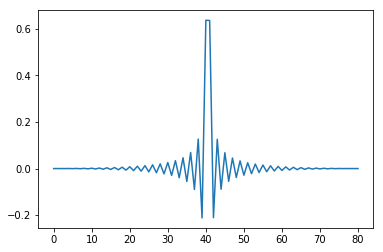

In [2]:
N = 81
t0 = 0.5
window = np.hanning(N)*np.sinc(np.arange(N) - (N-1)/2 - t0)
plt.plot(window)

In [3]:
def rad2freq(rad, fs):
    return rad * (fs/2) / np.pi

In [4]:
from scipy import signal

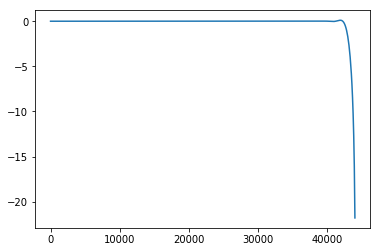

In [5]:
fs = 88200
w, h = signal.freqz(window)
plt.plot([rad2freq(rad, fs) for rad in w], 20 * np.log10(abs(h)))

In [6]:
names = ['west', 'east', 'south', 'north','floor', 'ceiling']
absorption = dict({'west':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6],'east':[0.2, 0.2, 0.3, 0.4, 0.5, 0.6],'south':[0.3, 0.2, 0.3, 0.4, 0.5, 0.6],'north':[0.4, 0.2, 0.3, 0.4, 0.5, 0.6],'floor':[0.5, 0.2, 0.3, 0.4, 0.5, 0.6],'ceiling':[0.6, 0.2, 0.3, 0.4, 0.5, 0.6]})
print(absorption)

{'west': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'east': [0.2, 0.2, 0.3, 0.4, 0.5, 0.6], 'south': [0.3, 0.2, 0.3, 0.4, 0.5, 0.6], 'north': [0.4, 0.2, 0.3, 0.4, 0.5, 0.6], 'floor': [0.5, 0.2, 0.3, 0.4, 0.5, 0.6], 'ceiling': [0.6, 0.2, 0.3, 0.4, 0.5, 0.6]}


<a id='room'></a>
## Creating a 2D/3D room

We can build an arbitrary room by specifing its corners on a plane.

In [7]:
corners = np.array([[0,0], [0,3], [5,3], [5,2], [2,2], [2,0]]).T  # [x,y]
absorption_ = [[1, 0, 1, 0, 1, 0],
              [1, 0, 1, 0, 1, 0],
              [1, 0, 1, 0, 1, 0],
              [1, 0, 1, 0, 1, 0],
              [1, 0, 1, 0, 1, 0],
              [1, 0, 1, 0, 1, 0],]

If we wish to build a 3D room, we can "lift" the 2D shape by a specified height.

room = pra.Room.from_corners(corners, blop=1)
room.extrude(2.)

fig, ax = room.plot()
ax.set_xlim([0, 5])
ax.set_ylim([0, 3])
ax.set_zlim([0, 2]);

<a id='source_mic'></a>
## Adding sources and microphones

We can conveniently add sources to the room using the `add_source` method. We can also set a `numpy` array as the source's signal.

The speech file comes from the [CMU Arctic Database](http://www.festvox.org/cmu_arctic/).

# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")

# add source to 2D room
room = pra.Room.from_corners(corners, fs=fs, absorption = absorption_)
room.add_source([1.,1.], signal=signal)

fig, ax = room.plot()

And similarly add a microphone array.

R = pra.circular_2D_array(center=[3.,2.5], M=6, phi0=0, radius=0.1)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()

<a id='rir'></a>
## Room impulse response (RIR) generation and propagation simulation

Using the Image Source Model (ISM) we can compute the impulse response for each microphone. From the `Room` constructor it is possible to set the maximum ISM order and the absorption coefficient.

In [8]:
corners_ = np.array([[0,0], [0,5], [5,5], [5,3], [2,3], [2,0]]).T  # [x,y]
absorption_ = [[0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
               [0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
               [0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
               [0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
               [0, 1, 0, 1, 0, 1],
               [0, 1, 0, 1, 0, 1]]
abs_ceil_floor = [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                  [0.6, 0.6, 0.6, 0.6, 0.6, 0.6]]

In [9]:
absorption_ = [[0, 0, 0, 1, 1, 1],
               [0, 0, 0, 1, 1, 1],
               [0, 0, 0, 1, 1, 1],
               [0, 0, 0, 1, 1, 1],
               [0, 0, 0, 1, 1, 1],
               [0, 0, 0, 1, 1, 1]]
abs_ceil_floor = [[0, 0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 1, 1]]

In [10]:
# specify signal source
fs, signal = wavfile.read("arctic_a0010.wav")
# set max_order to a low value for a quick (but less accurate) RIR
room = pra.Room.from_corners(corners_, fs=fs, max_order=1, absorption=absorption_)
room.extrude(1., absorption = abs_ceil_floor)

# add source and set the signal to WAV file content
room.add_source([1., 2., 0.5], signal=signal)

# add two-microphone array
R = np.array([[4.], [4.], [0.5]])  # [[x], [y], [z]]
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

In [11]:
# compute image sources
room.image_source_model(use_libroom=False)

initial: [[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
final: [[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


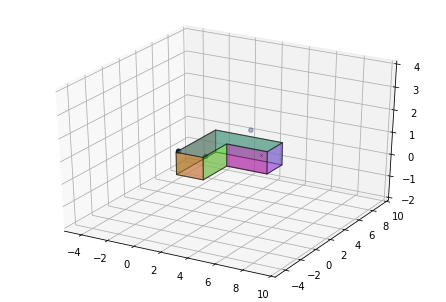

In [12]:
# visualize 3D polyhedron room and image sources
fig, ax = room.plot(img_order=3)
ax.set_xlim([-5, 10])
ax.set_ylim([-5, 10])
ax.set_zlim([-2, 4]);

Moreover, we can plot the RIR for each microphone once the image sources have been computed.

16000
Cython-extension build_rir unavailable. Falling back to pure python


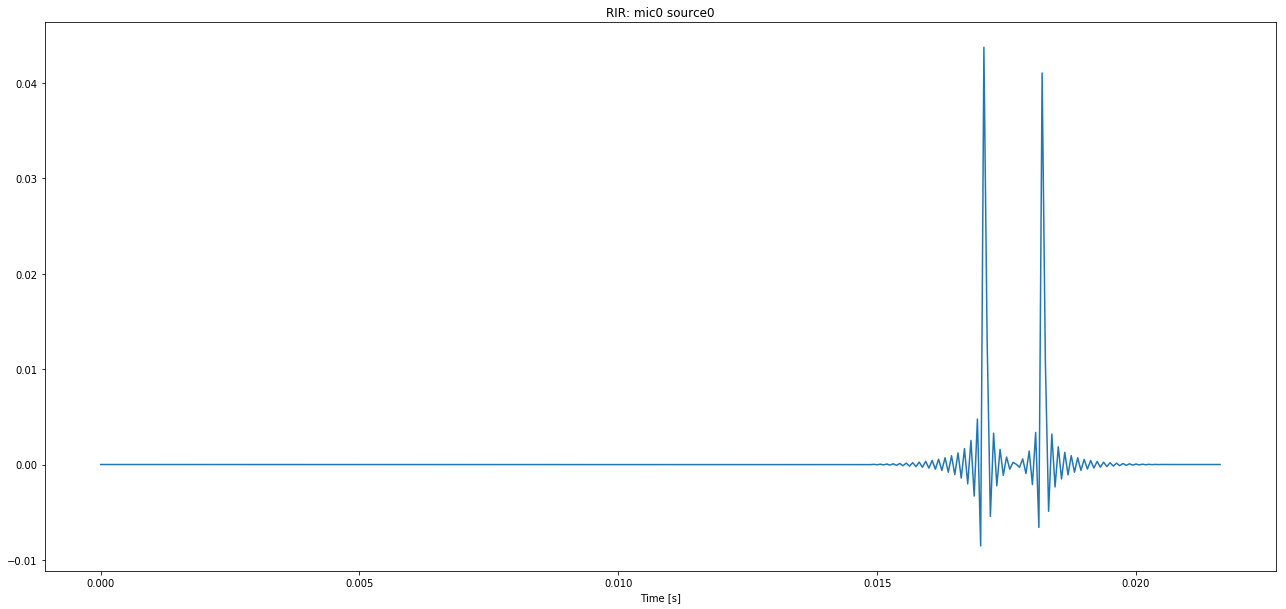

In [13]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

Moreover, we can simulate our signal convolved with these impulse responses as such:

In [14]:
room.simulate()
print(room.mic_array.signals.shape)

(1, 57386)


Let's listen to the output!

In [15]:
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [16]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:].astype(signal.dtype), rate=fs)

Simulated propagation to first mic:


In [17]:
signal.dtype

dtype('int16')

In [18]:
room.mic_array.signals.dtype

dtype('float64')

In [19]:
room.mic_array.signals.max()

838.34459213256

In [20]:
Fs = 88200
a = [0.9,0.8,0.7,0.8,0.9, 0.5]
f = [125,250,500,1000,2000,4000]
ranges = [[fr*3/4,fr*3/2] for fr in f]
ranges[0][0] = 1
ranges[5][1] = 44099
taps= np.zeros((6,512))
for i in range(6):
    taps[i] = (a[i]*sg.firwin(numtaps=512,
                       cutoff=ranges[i],
                       fs=Fs,
                       pass_zero=False, 
                       window='hamming',
                       scale=False))
taps = np.sum(taps, axis=0)

In [21]:
y = sg.lfilter(taps, 1, signal)

C:\Users\Martin\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [22]:
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [23]:
print("Simulated propagation to first mic:")
IPython.display.Audio(y.astype(signal.dtype), rate=fs)

Simulated propagation to first mic:
